In [79]:
# Useful starting lines
%matplotlib inline
import pandas as pd
import seaborn as sns
from IPython.display import display
import numpy as np
import sys
import matplotlib.pyplot as plt
from implementations import *

%load_ext autoreload
%autoreload 2

# Data input and output paths
DATA_TRAIN_PATH = '../data/train.csv' 
DATA_TEST_PATH = '../data/test.csv'
OUTPUT_PATH = 'predictions_out.csv'

# For debugging purpose
np.set_printoptions(threshold= 50)
np.random.seed(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [125]:
from proj1_helpers import *
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Analyse Data

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,1,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,-1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,0.879,1.414,NaN,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002,-1,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,3.776,1.414,NaN,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003,-1,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,2.354,-1.285,NaN,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004,-1,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,1.056,-1.385,NaN,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,211886.000000,250000.000000,250000.000000,250000.000000,72543.000000,72543.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,150087.000000,150087.000000,150087.000000,72543.000000,72543.000000,72543.000000,250000.000000
mean,224999.500000,-0.314664,121.858528,49.239819,81.181982,57.895962,2.403735,371.783360,-0.821688,2.373100,18.917332,158.432217,1.437609,-0.128305,0.458290,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,84.822105,-0.003275,-0.012393,57.679474,-0.011845,-0.001582,73.064591
std,72168.927986,0.949205,57.298157,35.344886,40.828691,63.655682,1.742226,397.699325,3.584362,0.782911,22.273494,115.706115,0.844743,1.193585,0.398681,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,60.662276,1.784546,1.813385,31.985782,2.031743,1.816950,98.015662
min,100000.000000,-1.000000,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,46.104000,0.047000,-1.414000,0.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000
25%,162499.750000,-1.000000,91.885250,19.241000,59.388750,14.068750,0.882500,111.977000,-2.629000,1.810000,2.841000,77.550000,0.883000,-1.371000,0.004000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,44.422500,-1.342000,-1.584000,37.312000,-1.612000,-1.576500,0.000000
50%,224999.500000,-1.000000,112.406000,46.524000,73.752000,38.467500,2.107000,225.885000,-0.244000,2.491500,12.315500,120.664500,1.280000,-0.356000,0.454000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,65.561000,0.000000,-0.033000,47.902000,-0.010000,-0.002000,40.512500
75%,287499.250000,1.000000,135.482000,73.598000,92.259000,79.169000,3.690000,478.226000,0.958000,2.961000,27.591000,200.478250,1.777000,1.225000,0.879000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,103.342000,1.336000,1.562000,66.637000,1.589500,1.576000,109.933750
max,349999.000000,1.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


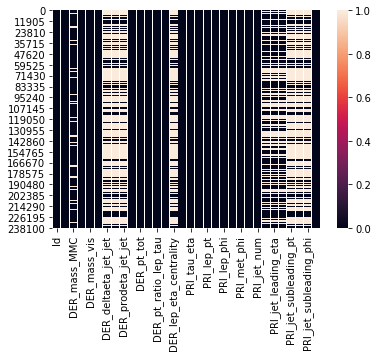

In [124]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
data = pd.read_csv(DATA_TRAIN_PATH, header=0, na_values='-999', delimiter=',')
#data.loc[[data['Prediction'].str.contains('s')],'Prediction'] = 1
#data.loc[[data['Prediction'].str.contains('b', na=False)],'Prediction'] = -1
#data[data < -998] = np.nan
#from sklearn.decomposition import PCA
#pca = PCA(n_components=30)
#pca.fit(tX)

#tX_pca = pca.transform(tX)
#print("original shape:   ", tX.shape)
#print("transformed shape:", tX_pca.shape)
indicesS = data[data['Prediction'].str.contains('s')].index
indicesB = pd.Int64Index(np.arange(len(data))).difference(indicesS)
data.loc[indicesS, 'Prediction'] = np.ones(len(indicesS))
data.loc[indicesB, 'Prediction'] = np.ones(len(indicesB))-2

sns.heatmap(data.isna())
display(data.head())
display(data.describe())


## Clean the data

In [48]:
def cleanData(tX):
    # Remove features with unusable data 
    unique, counts = np.unique(np.where(tX < -998)[1], return_counts=True)
    print(dict(zip(unique, counts)))
    tX = np.delete(tX, (0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28), 1)

    # Standardize the data
    tX, mean_x, std_x = standardize(tX)
    
    tX = normalize(tX)
    
    return tX

clean_tX = cleanData(tX)

pca = PCA(n_components=1)
pca.fit(clean_tX)

clean_tX = pca.transform(clean_tX)
print("original shape:   ", clean_tX.shape)
print("transformed shape:", tX_pca.shape)

{0: 38114, 4: 177457, 5: 177457, 6: 177457, 12: 177457, 23: 99913, 24: 99913, 25: 99913, 26: 177457, 27: 177457, 28: 177457}
original shape:    (250000, 1)
transformed shape: (250000, 1)


## Split the data into, training, validation and test sets

In [126]:

# How much annotated data for training and validation. The rest is used for testing.
training_perc, validation_perc = 0.4, 0.1

indices = np.arange(len(y))
np.random.shuffle(indices)

splits = (np.array([training_perc, validation_perc]) * len(y)).astype(int).cumsum()
training_indices, validation_indices, test_indices = np.split(indices, splits)

tX_train = clean_tX[training_indices]
y_train = y[training_indices]
ids_train = ids[training_indices]

tX_validation = clean_tX[validation_indices]
y_validation = y[validation_indices]
ids_validation = ids[validation_indices]

tX_test = clean_tX[test_indices]
y_test = y[test_indices]
ids_test = ids[test_indices]

## Parameter Exploration

## Regression 

In [147]:
initial_w = np.zeros(clean_tX.shape[1])
#initial_w = np.random.normal(0, 0.1, [tX.shape[1],])
max_iters = 500
gamma = 0.01
lambda_ = 0.5
degree = 3

from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(tX_train,y_train)
weights = logmodel.coef_



loss, weights_1 = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
loss, weights_2 = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
loss, weights_3 = least_squares(y_train, tX_train)
loss, weights_4 = ridge_regression(y_train, tX_train, lambda_)
loss, weights_5 = logistic_regression(y_train, tX_train, initial_w, max_iters, gamma)
loss, weights_6 = reg_logistic_regression(y_train, tX_train, lambda_, initial_w, max_iters, gamma)


#predictions = logmodel.predict(tX_test)
predictions = predict_labels(weights, tX_test)
predictions_1 = predict_labels(weights_1, tX_test)
predictions_2 = predict_labels(weights_2, tX_test)
predictions_3 = predict_labels(weights_3, tX_test)
predictions_4 = predict_labels(weights_4, tX_test)
predictions_5 = predict_labels(weights_5, tX_test)
predictions_6 = predict_labels(weights_6, tX_test)

from sklearn.metrics import classification_report
print("", classification_report(y_test,predictions))
print(classification_report(y_test,predictions_1))
print(classification_report(y_test,predictions_2))
print(classification_report(y_test,predictions_3))
print(classification_report(y_test,predictions_4))
print(classification_report(y_test,predictions_5))
print(classification_report(y_test,predictions_6))
#print("Loss: ", loss)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Current iteration=0, loss=64583.50562186956
Current iteration=100, loss=2147202.8360472624
Current iteration=200, loss=3177530.689400627
Current iteration=300, loss=731908.7194096997
Current iteration=400, loss=1880013.151046998
Current iteration=0, loss=1391240.2745307148
Current iteration=100, loss=2094127.3085291581
Current iteration=200, loss=951053.167187308
Current iteration=300, loss=1714550.0342812866
Current iteration=400, loss=765765.8225505435
              precision    recall  f1-score   support

        -1.0       0.77      0.59      0.67     82053
         1.0       0.46      0.67      0.55     42947

    accuracy                           0.62    125000
   macro avg       0.62      0.63      0.61    125000
weighted avg       0.67      0.62      0.63    125000

              precision    recall  f1-score   support

        -1.0       0.54      0.41      0.47     82053
         1.0       0.23      0.33      0.27     42947

    accuracy                           0.38    125

In [46]:
compute_mse_loss(y, clean_tX, weights)


3732.4445781283466

## Generate predictions and save ouput in csv format for submission:

In [ ]:
y, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test = cleanData(tX_test)

print(y.shape)
print(tX_test.shape)
print(weights.shape)

In [ ]:
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
print(y_pred.shape)
print(y.shape)